In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Nov  7 15:04:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import pandas as pd
import re
import spacy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import xgboost as xgb


# Data Cleaning


In [ ]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv = '/content/drive/My Drive/Colab Notebooks/consumer_complaints.csv'
df = pd.read_csv(csv)

In [ ]:
df.sample(5)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
93212,06/11/2014,Debt collection,Credit card,Taking/threatening an illegal action,Threatened to sue on too old debt,NaN,NaN,Bank of America,CA,92869,NaN,NaN,Web,06/11/2014,Closed with explanation,Yes,No,890371
490235,02/29/2016,Debt collection,Credit card,Disclosure verification of debt,Not given enough info to verify debt,"I have called Nationwide Credit , Inc. to get ...",Company has responded to the consumer and the ...,"Altisource Portfolio Solutions, S.Ã r.l.",KY,409XX,NaN,Consent provided,Web,02/29/2016,Closed with explanation,Yes,No,1809133
402264,12/08/2011,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Citibank,TX,75093,NaN,NaN,Web,12/08/2011,Closed with relief,Yes,Yes,4009
337304,06/18/2012,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,MA,02210,NaN,NaN,Web,06/22/2012,Closed with explanation,Yes,Yes,103414
129085,09/12/2014,Mortgage,Conventional adjustable mortgage (ARM),Settlement process and costs,NaN,NaN,NaN,"Select Portfolio Servicing, Inc",CA,90745,NaN,NaN,Web,09/12/2014,Closed with explanation,Yes,No,1025864


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [ ]:
df.isnull().sum()

date_received                        0
product                              0
sub_product                     158322
issue                                0
sub_issue                       343335
consumer_complaint_narrative    489151
company_public_response         470833
company                              0
state                             4887
zipcode                           4505
tags                            477998
consumer_consent_provided       432499
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         0
timely_response                      0
consumer_disputed?                   0
complaint_id                         0
dtype: int64

In [ ]:
df1 = df.dropna(subset=['consumer_complaint_narrative', 'product'])

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 66806 non-null  object
 1   product                       66806 non-null  object
 2   sub_product                   46351 non-null  object
 3   issue                         66806 non-null  object
 4   sub_issue                     32932 non-null  object
 5   consumer_complaint_narrative  66806 non-null  object
 6   company_public_response       32776 non-null  object
 7   company                       66806 non-null  object
 8   state                         66620 non-null  object
 9   zipcode                       66617 non-null  object
 10  tags                          11417 non-null  object
 11  consumer_consent_provided     66806 non-null  object
 12  submitted_via                 66806 non-null  object
 13  date_sent_

In [ ]:
df1['product'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64

In [ ]:
df1.loc[df1['product'].isin(['Consumer Loan', 'Student loan', 'Payday loan'])]

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
190135,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
190264,03/19/2015,Consumer Loan,Vehicle loan,Taking out the loan or lease,NaN,I applied for a loan with XXXX XXXX and had pu...,NaN,Hyundai Capital America,MS,392XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1292159
190710,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I have a car loan with PNC bank. In XXXX of 20...,NaN,PNC Bank N.A.,MD,212XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290617
191554,03/19/2015,Student loan,Non-federal student loan,Can't repay my loan,Can't decrease my monthly payments,I am trying to deal with Navient ( formerly XX...,NaN,"Navient Solutions, Inc.",NY,142XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290841
191998,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Around XXXX we consolidated our loans and paid...,NaN,TD Bank US Holding Company,TN,377XX,NaN,Consent provided,Web,03/25/2015,Closed with explanation,Yes,Yes,1290968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552696,01/31/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Company is using unfair collection practices t...,Company has responded to the consumer and the ...,"American Credit Acceptance, LLC",NE,681XX,NaN,Consent provided,Web,02/12/2016,Closed with explanation,Yes,No,1765971
552748,01/20/2016,Student loan,Non-federal student loan,Can't repay my loan,Can't get flexible payment options,"Sallie Mae, pulled my co-signer 's credit repo...",Company believes it acted appropriately as aut...,Sallie Mae,TX,752XX,NaN,Consent provided,Web,01/20/2016,Closed with explanation,Yes,No,1749620
552871,04/07/2016,Student loan,Non-federal student loan,Can't repay my loan,Can't get flexible payment options,I was mislead on all information on the predat...,Company believes complaint caused principally ...,Genesis Lending,ND,588XX,NaN,Consent provided,Web,04/07/2016,Closed with explanation,Yes,No,1869939
552906,02/11/2016,Consumer Loan,Vehicle loan,Shopping for a loan or lease,NaN,"They will not refinance my auto loan, but will...",NaN,Santander Consumer USA Holdings Inc,NJ,087XX,NaN,Consent provided,Web,02/11/2016,Closed with explanation,Yes,No,1783413


In [ ]:
df1.drop(df1.loc[df1['product'].isin(['Other financial service', 'Money transfers', 'Prepaid card'])].index, inplace = True)

In [ ]:
df1['product'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Payday loan                  726
Name: product, dtype: int64

In [ ]:
df1['product'].replace("Consumer Loan", "Loans", inplace=True)
df1['product'].replace("Student loan", "Loans", inplace=True)
df1['product'].replace("Payday loan", "Loans", inplace=True)

In [ ]:
df1['product'].value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Loans                       6532
Bank account or service     5711
Name: product, dtype: int64

In [ ]:
df1.sample(1000)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
323500,01/22/2016,Credit card,NaN,Delinquent account,NaN,I currently have a billing dispute regarding m...,NaN,JPMorgan Chase & Co.,MN,559XX,NaN,Consent provided,Web,01/22/2016,Closed with explanation,Yes,Yes,1753164
245157,07/11/2015,Loans,Non-federal student loan,Can't repay my loan,Can't get flexible payment options,While attending XXXX University I was denied f...,NaN,ACS Education Services,PA,170XX,NaN,Consent provided,Web,07/11/2015,Closed with explanation,Yes,No,1463456
258401,07/09/2015,Debt collection,Medical,Communication tactics,Frequent or repeated calls,They called me XXXX times in a matter of XXXX ...,NaN,"HOVG, LLC",FL,327XX,NaN,Consent provided,Web,07/09/2015,Closed with explanation,Yes,No,1459230
529855,02/21/2016,Credit reporting,NaN,Incorrect information on credit report,Account terms,I have items on my credit that does not belong...,NaN,Equifax,GA,300XX,NaN,Consent provided,Web,02/21/2016,Closed with explanation,Yes,No,1796635
275721,08/31/2015,Mortgage,FHA mortgage,"Loan servicing, payments, escrow account",NaN,Having problems with my bank Seterus over escr...,NaN,"Seterus, Inc.",MA,010XX,NaN,Consent provided,Web,08/31/2015,Closed with explanation,Yes,Yes,1545261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284543,09/10/2015,Credit card,NaN,Delinquent account,NaN,I am under the impression that Capital One is ...,NaN,Capital One,AL,352XX,NaN,Consent provided,Web,09/10/2015,Closed with explanation,Yes,No,1558230
306866,11/10/2015,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt is not mine,hello I received a debt collection notice from...,NaN,Encore Capital Group,MI,480XX,NaN,Consent provided,Web,11/10/2015,Closed with non-monetary relief,Yes,No,1648006
243417,07/10/2015,Mortgage,Conventional adjustable mortgage (ARM),"Application, originator, mortgage broker",NaN,I have been getting a run around from first me...,NaN,FirstMerit Bank,OH,432XX,NaN,Consent provided,Web,07/10/2015,Closed with explanation,Yes,No,1461949
548309,09/24/2015,Credit reporting,NaN,Unable to get credit report/credit score,Problem getting my free annual report,Well for two years i been trying to get my cre...,NaN,Equifax,NY,120XX,NaN,Consent provided,Web,09/25/2015,Closed with explanation,Yes,No,1579461


In [ ]:
df1.isnull().sum()

date_received                       0
product                             0
sub_product                     20455
issue                               0
sub_issue                       32237
consumer_complaint_narrative        0
company_public_response         32835
company                             0
state                             167
zipcode                           170
tags                            53982
consumer_consent_provided           0
submitted_via                       0
date_sent_to_company                0
company_response_to_consumer        0
timely_response                     0
consumer_disputed?                  0
complaint_id                        0
dtype: int64

In [ ]:
df1.tags.value_counts

<bound method IndexOpsMixin.value_counts of 190126    Older American
190135     Servicemember
190155               NaN
190207    Older American
190208    Older American
               ...      
553084               NaN
553085               NaN
553086     Servicemember
553090               NaN
553096               NaN
Name: tags, Length: 65169, dtype: object>

In [ ]:
del df1['sub_product']

In [ ]:
del df1['sub_issue']
del df1['tags']


In [ ]:
df1.company_public_response.value_counts()

Company chooses not to provide a public response                                                                           19104
Company believes it acted appropriately as authorized by contract or law                                                    6398
Company has responded to the consumer and the CFPB and chooses not to provide a public response                             3670
Company disputes the facts presented in the complaint                                                                        687
Company believes complaint caused principally by actions of third party outside the control or direction of the company      651
Company believes the complaint is the result of a misunderstanding                                                           631
Company believes complaint is the result of an isolated error                                                                481
Company can't verify or dispute the facts in the complaint                                       

In [ ]:
del df1['company_public_response']

In [ ]:
df1 = df1.dropna(subset=['state', 'zipcode'])

In [ ]:
df1.isnull().sum()

date_received                   0
product                         0
issue                           0
consumer_complaint_narrative    0
company                         0
state                           0
zipcode                         0
consumer_consent_provided       0
submitted_via                   0
date_sent_to_company            0
company_response_to_consumer    0
timely_response                 0
consumer_disputed?              0
complaint_id                    0
dtype: int64

In [ ]:
del df

In [ ]:
df1["consumer_complaint_narrative"].isnull().value_counts()

False    64999
Name: consumer_complaint_narrative, dtype: int64

In [ ]:
df1.sample(5)

,date_received,product,issue,consumer_complaint_narrative,company,state,zipcode,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
245026,07/10/2015,Mortgage,"Loan modification,collection,foreclosure",The reason for the complaint is that I have be...,Wells Fargo & Company,CA,902XX,Consent provided,Web,07/17/2015,Closed with explanation,Yes,No,1462929
208656,03/24/2015,Mortgage,"Loan modification,collection,foreclosure",My mortgage company is giving me the run aroun...,Nationstar Mortgage,NJ,080XX,Consent provided,Web,03/24/2015,Closed with explanation,Yes,No,1297294
513218,02/02/2016,Credit reporting,Incorrect information on credit report,"their is an address of XXXX, Md XXXX that does...",Equifax,WV,249XX,Consent provided,Web,02/02/2016,Closed with explanation,Yes,No,1766373
272761,08/25/2015,Credit reporting,Incorrect information on credit report,XXXX address and XXXX names listed under Trans...,"TransUnion Intermediate Holdings, Inc.",MN,551XX,Consent provided,Web,08/25/2015,Closed with non-monetary relief,Yes,No,1534800
524544,02/23/2016,Bank account or service,Problems caused by my funds being low,I notified TD Bank in writing that I filed a C...,TD Bank US Holding Company,NY,100XX,Consent provided,Web,02/23/2016,Closed with explanation,Yes,No,1800814


In [ ]:
df1.consumer_consent_provided.value_counts()

Consent provided    64999
Name: consumer_consent_provided, dtype: int64

In [ ]:
df1.rename(columns={"consumer_complaint_narrative": "complaint"}, inplace = True)

In [ ]:
del df1['consumer_consent_provided']

In [ ]:
del df1['issue']

In [ ]:
del df1['complaint_id']

In [ ]:
df = df1.copy()

In [ ]:
dump1 = '/content/drive/My Drive/Colab Notebooks/df_clean_01.csv'
df1.to_csv(dump1, index=None)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_clean_01.csv')

In [ ]:
#dump1 = '/content/drive/My Drive/Colab Notebooks/df_clean_01.csv'
#df1.to_csv(dump1, index=None)
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_clean_01.csv')

In [ ]:
del df1

In [ ]:
df.head()

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?
0,03/19/2015,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...,"Diversified Consultants, Inc.",NY,121XX,Web,03/19/2015,Closed with explanation,Yes,No
1,03/19/2015,Loans,Due to inconsistencies in the amount owed that...,M&T Bank Corporation,VA,221XX,Web,03/19/2015,Closed with explanation,Yes,No
2,03/19/2015,Mortgage,In XX/XX/XXXX my wages that I earned at my job...,Wells Fargo & Company,CA,946XX,Web,03/19/2015,Closed with explanation,Yes,Yes
3,03/19/2015,Mortgage,I have an open and current mortgage with Chase...,JPMorgan Chase & Co.,CA,900XX,Web,03/19/2015,Closed with explanation,Yes,Yes
4,03/19/2015,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...,Rushmore Loan Management Services LLC,CA,956XX,Web,03/19/2015,Closed with explanation,Yes,Yes


In [ ]:
labels = {"product": {"Debt collection": 1, "Mortgage": 2, "Credit reporting": 3, "Credit card": 4, "Loans": 5, "Bank account or service": 6} }

In [ ]:
labels

{'product': {'Bank account or service': 6,
  'Credit card': 4,
  'Credit reporting': 3,
  'Debt collection': 1,
  'Loans': 5,
  'Mortgage': 2}}

In [ ]:
df['label'] = df['product']

In [ ]:
df = df.replace(labels)

In [ ]:
df.sample(10)

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,label
60651,02/03/2016,6,"On XXXX XXXX, 2015 I used my Wells Fargo ATM c...",Wells Fargo & Company,CA,958XX,Web,02/03/2016,Closed with explanation,No,No,Bank account or service
15295,06/04/2015,2,My second mortgage Citimortgage. The terms of ...,Citibank,HI,967XX,Web,06/04/2015,Closed with explanation,Yes,No,Mortgage
13571,06/22/2015,6,"Bank owners rob clients. \nI, XXXX XXXX, accus...",U.S. Bancorp,AZ,863XX,Web,06/23/2015,Closed with explanation,Yes,No,Bank account or service
38051,09/23/2015,2,In XX/XX/XXXX my boyfriend and I purchased my ...,TCF National Bank,MN,554XX,Web,09/23/2015,Closed with monetary relief,Yes,No,Mortgage
44570,11/13/2015,1,I received a phone call from a company called ...,"Enova International, Inc.",MI,483XX,Web,11/13/2015,Closed with explanation,Yes,No,Debt collection
21379,08/07/2015,3,A few months ago I requested my credit report ...,Experian,NV,891XX,Web,08/07/2015,Closed with explanation,Yes,No,Credit reporting
946,04/04/2015,2,My father was a XXXX Veteran. He purchased a h...,Banco Santander Puerto Rico,PR,006XX,Web,04/28/2015,Closed with explanation,Yes,No,Mortgage
61067,02/19/2016,2,I purchased and closed on a manufactured house...,Vanderbilt Mortgage & Finance,TX,773XX,Web,02/19/2016,Closed with explanation,Yes,No,Mortgage
1758,04/07/2015,1,On XXXX XXXX I transferred responsibility of m...,Allied Interstate LLC,CA,953XX,Web,04/07/2015,Closed with non-monetary relief,Yes,No,Debt collection
32483,10/08/2015,2,For the past year my family and I have been tr...,Ocwen,WA,982XX,Web,10/08/2015,Closed with explanation,Yes,No,Mortgage


In [ ]:
df.rename(columns={"consumer_disputed?": "consumer_disputed"}, inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64999 entries, 0 to 64998
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 64999 non-null  object
 1   product                       64999 non-null  int64 
 2   complaint                     64999 non-null  object
 3   company                       64999 non-null  object
 4   state                         64999 non-null  object
 5   zipcode                       64999 non-null  object
 6   submitted_via                 64999 non-null  object
 7   date_sent_to_company          64999 non-null  object
 8   company_response_to_consumer  64999 non-null  object
 9   timely_response               64999 non-null  object
 10  consumer_disputed             64999 non-null  object
 11  label                         64999 non-null  object
dtypes: int64(1), object(11)
memory usage: 6.0+ MB


# Regex & NLP Cleaning

In [ ]:
pattern = r'\bX+'
df['complaint'] = df['complaint'].apply(lambda x: re.sub(pattern,'', x))

In [ ]:
pattern = re.compile(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]")
df['complaint'] = df['complaint'].apply(lambda x: re.sub(pattern,'', x))

In [ ]:
df['complaint'] = df['complaint'].apply(lambda x: x.lower())

In [ ]:
df.head(10)

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,label
0,03/19/2015,1,has claimed i owe them 2700 for years despit...,"Diversified Consultants, Inc.",NY,121XX,Web,03/19/2015,Closed with explanation,Yes,No,Debt collection
1,03/19/2015,5,due to inconsistencies in the amount owed that...,M&T Bank Corporation,VA,221XX,Web,03/19/2015,Closed with explanation,Yes,No,Loans
2,03/19/2015,2,in my wages that i earned at my job decreased...,Wells Fargo & Company,CA,946XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage
3,03/19/2015,2,i have an open and current mortgage with chase...,JPMorgan Chase & Co.,CA,900XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage
4,03/19/2015,2,was submitted at the time i submitted this c...,Rushmore Loan Management Services LLC,CA,956XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage
5,03/19/2015,2,experian is reporting my open and current mort...,Experian,CA,900XX,Web,03/25/2015,Closed with explanation,Yes,No,Mortgage
6,03/19/2015,2,this complaint is against wells fargo bank for...,Wells Fargo & Company,CA,931XX,Web,03/19/2015,Closed with explanation,Yes,No,Mortgage
7,03/19/2015,2,i spoke to of green tree representatives on ...,Ditech Financial LLC,CA,948XX,Web,03/19/2015,Closed with non-monetary relief,Yes,No,Mortgage
8,03/19/2015,4,i opened bank of america credit cards 1520 ye...,Bank of America,OR,971XX,Web,03/19/2015,Closed with monetary relief,Yes,Yes,Credit card
9,03/19/2015,5,i applied for a loan with and had purchased ...,Hyundai Capital America,MS,392XX,Web,03/19/2015,Closed with explanation,Yes,No,Loans


In [ ]:
df.complaint[9]

"i applied for a loan with   and had purchased  vehicle during the month of  2014 i was told that i would be getting a good deal on the vehicles in which i purchased i later found out that the interest rate charged for the loans at the time was almost  times that of the average consumer for the credit score that i had and when i came back to speak to the finance manager the dealership had let her go for fudging many of the loans and jacking up many customers interest in order to make a higher commission and she was no longer employed with the company due to her increasing many loans on the interest that some of their consumers were paying the dealership as of today 's date has never contacted me and had i not inquired i would have never known the truth when i applied my credit score was showing  approximately and thought that i would get the lowest interest rate at the dealership offered but instead i received an interest rate that was nearly  of that of the regular consumer i am reque

In [ ]:
pattern = r'\s+'
df['complaint'] = df['complaint'].apply(lambda x: re.sub(pattern,' ', x))

In [ ]:
df['complaint'] = df['complaint'].apply(lambda x: x.strip())

In [ ]:
df.complaint[9]

"i applied for a loan with and had purchased vehicle during the month of 2014 i was told that i would be getting a good deal on the vehicles in which i purchased i later found out that the interest rate charged for the loans at the time was almost times that of the average consumer for the credit score that i had and when i came back to speak to the finance manager the dealership had let her go for fudging many of the loans and jacking up many customers interest in order to make a higher commission and she was no longer employed with the company due to her increasing many loans on the interest that some of their consumers were paying the dealership as of today 's date has never contacted me and had i not inquired i would have never known the truth when i applied my credit score was showing approximately and thought that i would get the lowest interest rate at the dealership offered but instead i received an interest rate that was nearly of that of the regular consumer i am requesting a

In [ ]:
#NLP
nlp = spacy.load('en_core_web_sm')

In [ ]:
def clean_text(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        #print(token)
        if token.is_stop or token.is_punct or token.is_digit:
            continue
        else:
            tokens.append(token.lemma_)
    text = ' '.join(tokens)
    return text

In [ ]:
df.complaint[9]

"i applied for a loan with and had purchased vehicle during the month of 2014 i was told that i would be getting a good deal on the vehicles in which i purchased i later found out that the interest rate charged for the loans at the time was almost times that of the average consumer for the credit score that i had and when i came back to speak to the finance manager the dealership had let her go for fudging many of the loans and jacking up many customers interest in order to make a higher commission and she was no longer employed with the company due to her increasing many loans on the interest that some of their consumers were paying the dealership as of today 's date has never contacted me and had i not inquired i would have never known the truth when i applied my credit score was showing approximately and thought that i would get the lowest interest rate at the dealership offered but instead i received an interest rate that was nearly of that of the regular consumer i am requesting a

In [ ]:
clean_text(df.complaint[9])

'apply loan purchase vehicle month tell get good deal vehicle purchase later find interest rate charge loan time time average consumer credit score come speak finance manager dealership let fudge loan jack customer interest order high commission longer employ company increase loan interest consumer pay dealership today date contact inquired know truth apply credit score show approximately think low interest rate dealership offer instead receive interest rate nearly regular consumer request investigation lending loan service company base follow discrimination base race color gender charge high rate consumer different race gender color request immediate investigation loan process time apply everyday factor practice base race investigate transaction company advertise certain price sell vehicle advertise price like bait switch consumer predatory lending clearly everyday factor order finance department well commission consumer aware process work charge high rate reason greed fair accurate t

In [ ]:
df['complaint_cleaned'] = df.complaint.apply(clean_text)

In [ ]:
dump2 = '/content/drive/My Drive/Colab Notebooks/df_clean_02.csv'
df.to_csv(dump2, index=None)

In [ ]:
df.sample(5)

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,label,complaint_cleaned
52472,12/16/2015,3,and experian refuse to remove the accounts fro...,Experian,GA,303XX,Web,12/16/2015,Closed with non-monetary relief,Yes,No,Credit reporting,experian refuse remove account credit late inc...
22545,07/16/2015,1,this caller has been asked to stop calling my ...,"Genuine Debt Solutions, LLC.",PA,174XX,Web,07/16/2015,Untimely response,No,No,Debt collection,caller ask stop call place employment cease de...
33897,10/10/2015,2,i filed an qualified written respa request for...,"Servis One, Inc.",CA,945XX,Web,10/13/2015,Closed with explanation,Yes,No,Mortgage,file qualified write respa request information...
61300,01/30/2016,6,i had disputed a charge on my account for 3800...,Bank of America,TX,752XX,Web,01/30/2016,Closed with explanation,Yes,No,Bank account or service,dispute charge account faulty repair work frid...
19306,06/19/2015,5,i applied and was approved for credit at ashle...,Synchrony Financial,WA,980XX,Web,06/23/2015,Closed with non-monetary relief,Yes,Yes,Loans,apply approve credit ashley furniture cancel a...


In [ ]:
df.complaint[50]

"we opened an account with freedom funiture in paid as agreed and refinanced in we paid as agreed until we became unable to pay the full amount in we made an agreement to pay a lesser amount per month and kept paying via allotment freedom got a judgement against us while i was training i was not served with the judgement prior to court or after i was informed of it when my wages began to be garnished they got the judgement in va filed i did not sign a contract in va i signed my contract in ga they garnished my wages causing finacial distress i was able to get that stopped through however the judgement remains and has severely damaged our credit preventing us from buying a home and upgrading our vehicles we have asked repeatedly to have this issue fixed based on the fact that the judgement was not served on me ever and the fact that they have caused so much financial distress and ruin we were told we 'd have to go to va to fix it we have in total paid this company nearly 2500000 over th

In [ ]:
df.complaint_cleaned[50]

'open account freedom funiture pay agree refinance pay agree unable pay agreement pay less month keep pay allotment freedom get judgement train serve judgement prior court inform wage begin garnish get judgement va file sign contract va sign contract ga garnish wage cause finacial distress able stop judgement remain severely damage credit prevent buy home upgrade vehicle ask repeatedly issue fix base fact judgement serve fact cause financial distress ruin tell va fix total pay company nearly year couch loveseat computer hutch table chair furniture last payment ruin continue judgement say owe need assistance try step possible fix aid'

In [ ]:
del df['complaint']

# EDA

In [ ]:
df.date_received = pd.to_datetime(df.date_received)
df.date_sent_to_company = pd.to_datetime(df.date_sent_to_company)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64999 entries, 0 to 64998
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date_received                 64999 non-null  datetime64[ns]
 1   product                       64999 non-null  int64         
 2   company                       64999 non-null  object        
 3   state                         64999 non-null  object        
 4   zipcode                       64999 non-null  object        
 5   submitted_via                 64999 non-null  object        
 6   date_sent_to_company          64999 non-null  datetime64[ns]
 7   company_response_to_consumer  64999 non-null  object        
 8   timely_response               64999 non-null  object        
 9   consumer_disputed             64999 non-null  object        
 10  label                         64999 non-null  object        
 11  complaint_cleaned           

In [ ]:
df.date_received.min() ,df.date_received.max()

(Timestamp('2015-03-19 00:00:00'), Timestamp('2016-04-20 00:00:00'))

In [ ]:
df.label.value_counts()

Debt collection            17513
Mortgage                   14899
Credit reporting           12500
Credit card                 7904
Loans                       6523
Bank account or service     5660
Name: label, dtype: int64

In [ ]:
df['product'].value_counts()

1    17513
2    14899
3    12500
4     7904
5     6523
6     5660
Name: product, dtype: int64

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_clean_02.csv')

In [ ]:
df1 = df['label'].value_counts()
df1

Debt collection            17513
Mortgage                   14899
Credit reporting           12500
Credit card                 7904
Loans                       6523
Bank account or service     5660
Name: label, dtype: int64

In [ ]:
df.head()

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,label,complaint_cleaned
0,03/19/2015,1,has claimed i owe them 2700 for years despite ...,"Diversified Consultants, Inc.",NY,121XX,Web,03/19/2015,Closed with explanation,Yes,No,Debt collection,claim owe year despite proof payment send canc...
1,03/19/2015,5,due to inconsistencies in the amount owed that...,M&T Bank Corporation,VA,221XX,Web,03/19/2015,Closed with explanation,Yes,No,Loans,inconsistency owe tell m t bank report credit ...
2,03/19/2015,2,in my wages that i earned at my job decreased ...,Wells Fargo & Company,CA,946XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,wage earn job decrease half know trouble home ...
3,03/19/2015,2,i have an open and current mortgage with chase...,JPMorgan Chase & Co.,CA,900XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,open current mortgage chase bank chase report ...
4,03/19/2015,2,was submitted at the time i submitted this com...,Rushmore Loan Management Services LLC,CA,956XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,submit time submit complaint deal rushmore mor...


In [ ]:
df.submitted_via.value_counts()

Web    64999
Name: submitted_via, dtype: int64

In [ ]:
#df1.plot.pie(autopct="%.1f%%");

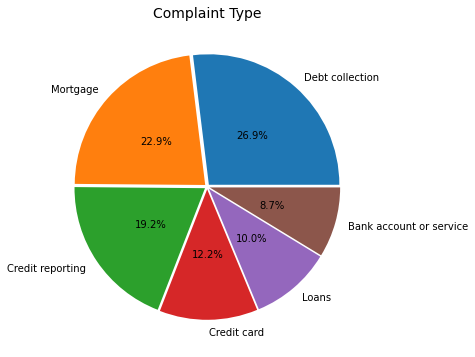

In [ ]:
pie, ax = plt.subplots(figsize=[10,6])
labels = df1.keys()
plt.pie(x=df1, autopct="%.1f%%", explode=[0.02]*6, labels=labels, pctdistance=0.5)
plt.title("Complaint Type", fontsize=14);

In [ ]:
#for submitted_type analysis - original dataset - EDA only
#in the cleaned dataset submitted_type is all WEB
csv = '/content/drive/My Drive/Colab Notebooks/consumer_complaints.csv'
dfx = pd.read_csv(csv)

In [ ]:
dfx.submitted_via.value_counts()

Web            361338
Referral       109379
Phone           40026
Postal mail     36752
Fax              8118
Email             344
Name: submitted_via, dtype: int64

In [ ]:
#dfx = dfx.dropna(subset=['consumer_complaint_narrative', 'product'])

In [ ]:
#dfx.submitted_via.value_counts()

In [ ]:
dfx.date_received = pd.to_datetime(dfx.date_received)
dfx.date_sent_to_company = pd.to_datetime(dfx.date_sent_to_company)

In [ ]:
dfx = dfx.loc[:,['submitted_via','date_received','date_sent_to_company']]
dfx['no_of_days'] = dfx['date_sent_to_company']-dfx['date_received']
dfx.sample(5)

,submitted_via,date_received,date_sent_to_company,no_of_days
495624,Postal mail,2016-03-03,2016-03-03,0 days
408382,Referral,2012-04-27,2012-05-01,4 days
546308,Web,2016-01-25,2016-02-01,7 days
192524,Web,2015-02-09,2015-02-09,0 days
260049,Web,2015-07-09,2015-07-09,0 days


In [ ]:
dfx2 = dfx.submitted_via.value_counts()
dfx2

Web            361338
Referral       109379
Phone           40026
Postal mail     36752
Fax              8118
Email             344
Name: submitted_via, dtype: int64

In [ ]:
dfx.drop(['date_received','date_sent_to_company'],axis=1,inplace=True)

In [ ]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   submitted_via  555957 non-null  object         
 1   no_of_days     555957 non-null  timedelta64[ns]
dtypes: object(1), timedelta64[ns](1)
memory usage: 8.5+ MB


In [ ]:
dfx['no_of_days'] = dfx['no_of_days'].dt.days

In [ ]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   submitted_via  555957 non-null  object
 1   no_of_days     555957 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.5+ MB


In [ ]:
df.company.value_counts()

Equifax                                   4187
Experian                                  3928
TransUnion Intermediate Holdings, Inc.    3850
Bank of America                           3430
Wells Fargo & Company                     3035
                                          ... 
Northway Broker Ltd.                         1
St John Rossin & Burr, PLLC                  1
Account Recovery Service, Inc. (WI)          1
First Peachtree Finance, Inc.                1
Account Information Management, Corp.        1
Name: company, Length: 2271, dtype: int64

In [ ]:
dfx = dfx.groupby('submitted_via').agg({'no_of_days':'mean'})
dfx.no_of_days = round(dfx.no_of_days,0)
dfx.sort_values('no_of_days',ascending=True,inplace=True)
dfx

,no_of_days
submitted_via,
Web,4.0
Phone,5.0
Referral,6.0
Fax,7.0
Email,8.0
Postal mail,10.0


In [ ]:
dfx2 =  dfx2.to_frame()
dfx2

,submitted_via
Web,361338
Referral,109379
Phone,40026
Postal mail,36752
Fax,8118
Email,344


Text(0.5, 1.0, 'Avg no. of days taken for the complaint to reach to the company depending upon the mode of submission')

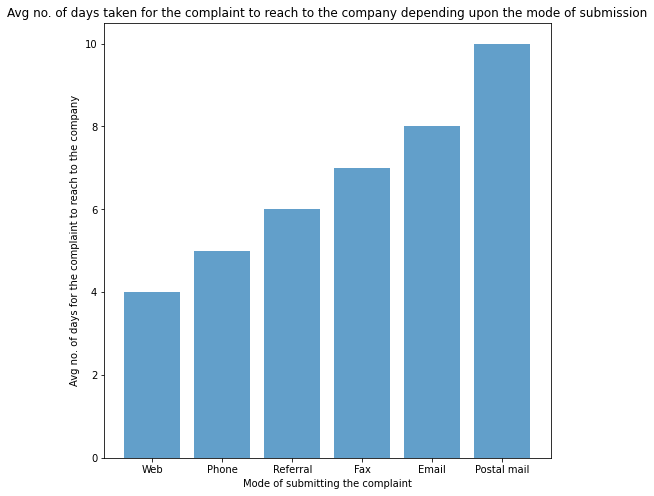

In [ ]:
plt.figure(figsize=(8,8))
plt.bar(dfx.index,dfx.no_of_days, color='C0', alpha=0.7)
plt.xlabel('Mode of submitting the complaint')
plt.ylabel('Avg no. of days for the complaint to reach to the company')
plt.title('Avg no. of days taken for the complaint to reach to the company depending upon the mode of submission')

Text(0.5, 1.0, 'Number of complaints by Subimitted Type')

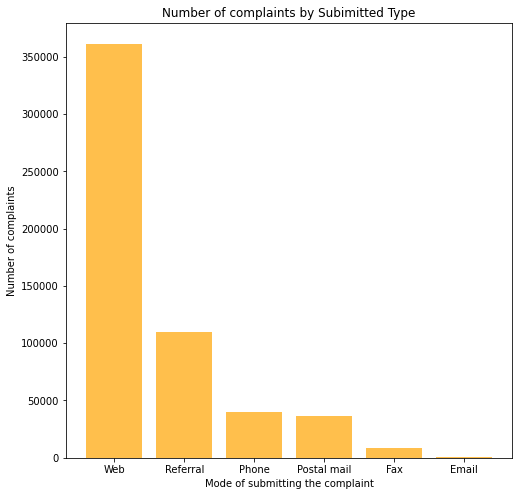

In [ ]:
plt.figure(figsize=(8,8))
plt.bar(dfx2.index, dfx2.submitted_via, color='orange', alpha=0.7)
plt.xlabel('Mode of submitting the complaint')
plt.ylabel('Number of complaints')
plt.title('Number of complaints by Subimitted Type')

In [ ]:
#main DF
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64999 entries, 0 to 64998
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 64999 non-null  object
 1   product                       64999 non-null  int64 
 2   complaint                     64999 non-null  object
 3   company                       64999 non-null  object
 4   state                         64999 non-null  object
 5   zipcode                       64999 non-null  object
 6   submitted_via                 64999 non-null  object
 7   date_sent_to_company          64999 non-null  object
 8   company_response_to_consumer  64999 non-null  object
 9   timely_response               64999 non-null  object
 10  consumer_disputed             64999 non-null  object
 11  label                         64999 non-null  object
 12  complaint_cleaned             64989 non-null  object
dtypes: int64(1), obj

(-0.5, 399.5, 199.5, -0.5)

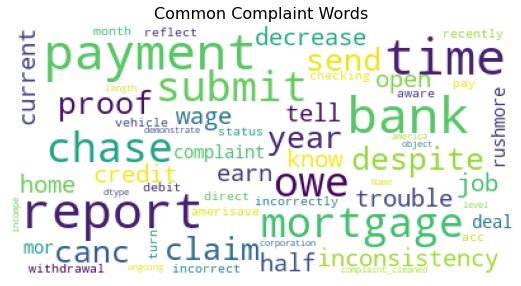

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40, 
    random_state=42
    ).generate(str(df.complaint_cleaned)
)

fig = plt.figure(figsize=(20,15))
fig.add_subplot(221)
plt.imshow(wordcloud)
plt.title('Common Complaint Words', fontsize=16)
plt.axis('off')

In [ ]:
dfcompanies = df.company.value_counts().to_frame()
dfcompanies = dfcompanies.head(10)
dfcompanies

,company
Equifax,4187
Experian,3928
"TransUnion Intermediate Holdings, Inc.",3850
Bank of America,3430
Wells Fargo & Company,3035
Citibank,2720
JPMorgan Chase & Co.,2550
Ocwen,1620
Capital One,1494
Nationstar Mortgage,1371


Text(0.5, 1.0, 'Number of complaints by Company (Top 10)')

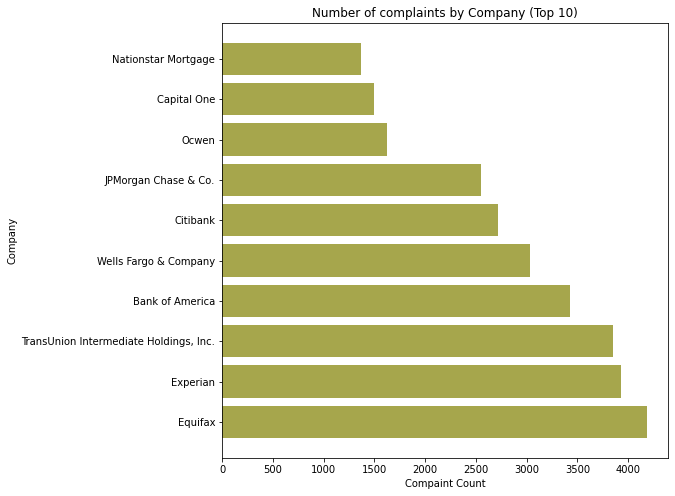

In [ ]:
plt.figure(figsize=(8,8))
plt.barh(dfcompanies.index, dfcompanies.company, color='olive', alpha=0.7)
plt.xlabel('Compaint Count')
plt.ylabel('Company')
plt.title('Number of complaints by Company (Top 10)')

In [ ]:
len(df.company.unique())

2271

In [ ]:
df[df.complaint_cleaned.isnull()]

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,label,complaint_cleaned
10912,06/07/2015,1,i did not have in 2011,ERC,CA,958XX,Web,06/08/2015,Closed with non-monetary relief,Yes,No,Debt collection,NaN
19423,07/08/2015,1,is not me,Stellar Recovery Inc.,FL,331XX,Web,07/13/2015,Closed with explanation,Yes,No,Debt collection,NaN
19819,07/08/2015,3,never had,"TransUnion Intermediate Holdings, Inc.",NY,142XX,Web,07/09/2015,Closed with explanation,Yes,No,Credit reporting,NaN
24760,08/28/2015,3,the name is not and never has been my name,"TransUnion Intermediate Holdings, Inc.",WA,984XX,Web,08/28/2015,Closed with non-monetary relief,Yes,No,Credit reporting,NaN
36263,10/26/2015,3,my name is not,Experian,TX,754XX,Web,10/28/2015,Closed with non-monetary relief,Yes,No,Credit reporting,NaN
44626,12/06/2015,1,this is not mine,Encore Capital Group,CA,914XX,Web,12/08/2015,Closed with explanation,Yes,Yes,Debt collection,NaN
54587,03/28/2016,3,my name is not,"TransUnion Intermediate Holdings, Inc.",TX,782XX,Web,03/28/2016,Closed with non-monetary relief,Yes,No,Credit reporting,NaN
57129,10/31/2015,1,this is not mine,"Duncan Solutions, lnc.",CA,937XX,Web,11/03/2015,Closed with explanation,No,No,Debt collection,NaN
57448,10/29/2015,1,never ever have i had in my name,Stellar Recovery Inc.,CA,945XX,Web,11/02/2015,Closed with explanation,Yes,No,Debt collection,NaN
60834,02/20/2016,3,the name us not my name,"TransUnion Intermediate Holdings, Inc.",TX,782XX,Web,02/22/2016,Closed with explanation,Yes,No,Credit reporting,NaN


In [ ]:
df = df.drop(df[df.complaint_cleaned.isnull()].index)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64989 entries, 0 to 64998
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 64989 non-null  object
 1   product                       64989 non-null  int64 
 2   complaint                     64989 non-null  object
 3   company                       64989 non-null  object
 4   state                         64989 non-null  object
 5   zipcode                       64989 non-null  object
 6   submitted_via                 64989 non-null  object
 7   date_sent_to_company          64989 non-null  object
 8   company_response_to_consumer  64989 non-null  object
 9   timely_response               64989 non-null  object
 10  consumer_disputed             64989 non-null  object
 11  label                         64989 non-null  object
 12  complaint_cleaned             64989 non-null  object
dtypes: int64(1), obj

In [ ]:
df['char_count'] = df['complaint_cleaned'].apply(len)
df['word_count'] = df['complaint_cleaned'].apply(lambda x: len(x.split()))

In [ ]:
df.sample(5)

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,label,complaint_cleaned,char_count,word_count
43195,11/12/2015,4,i have been in an on going dispute with citi b...,Citibank,MI,480XX,Web,11/12/2015,Closed with monetary relief,Yes,No,Credit card,go dispute citi bank give money week ago pay b...,227,39
39501,11/09/2015,5,capitol one autofinance has continually called...,Capital One,WI,541XX,Web,11/09/2015,Closed with explanation,Yes,Yes,Loans,capitol autofinance continually call employer ...,135,18
9967,05/17/2015,2,we closed on our new home at the end of 2014 o...,"Stearns Ventures, LLC",MO,640XX,Web,05/17/2015,Closed with explanation,Yes,No,Mortgage,close new home end title company hold money cl...,518,81
5966,05/13/2015,5,toyota financial service as aggressive and sne...,Toyota Motor Credit Corporation,MD,206XX,Web,05/13/2015,Closed with explanation,Yes,No,Loans,toyota financial service aggressive sneaky col...,751,107
36783,10/20/2015,3,experian is reporting charges as open and not ...,Experian,KY,421XX,Web,10/20/2015,Closed with non-monetary relief,Yes,No,Credit reporting,experian report charge open satisfied pay call...,79,11


In [ ]:
max(df['word_count']), max(df['char_count'])

(357, 2736)

# Topic Modelling

In [ ]:
import gensim #the library for Topic modelling
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models

from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.simplefilter('ignore')
from itertools import chain

In [ ]:
pip install pyldavis

     |████████████████████████████████| 1.7 MB 8.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 70.7 MB/s 
     |████████████████████████████████| 11.3 MB 58.6 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=fe534964678770a0c1e724d59efee0a7126f38c616d6cc996ea735b54ddf2a21
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take in

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean_split(text):
    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized.split()

In [ ]:
df['clean_split'] = df['complaint_cleaned'].apply(clean_split)

In [ ]:
df.sample(5)

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,label,complaint_cleaned,char_count,word_count,clean_split
6182,04/24/2015,1,i just checked my credit score and saw a 9 dol...,FMS Inc.,WA,984XX,Web,04/24/2015,Closed with explanation,Yes,No,Debt collection,check credit score see dollar medical bill col...,387,54,"[check, credit, score, see, dollar, medical, b..."
56726,12/21/2015,1,received a notice from allied international cr...,Allied International Credit Corporation,CA,900XX,Web,12/21/2015,Closed with explanation,Yes,No,Debt collection,receive notice ally international credit corp ...,161,23,"[receive, notice, ally, international, credit,..."
9483,06/05/2015,5,the name of the lady that contacted me is phon...,CNG Financial Corporation,TX,760XX,Web,06/05/2015,Closed with explanation,Yes,No,Loans,lady contact phone number say texas tell felon...,153,26,"[lady, contact, phone, number, say, texas, tel..."
9523,04/27/2015,1,a company called portfolio recovery from virgi...,"Portfolio Recovery Associates, Inc.",VA,201XX,Web,04/27/2015,Closed with explanation,Yes,Yes,Debt collection,company call portfolio recovery virginia repea...,585,89,"[company, call, portfolio, recovery, virginia,..."
31240,10/01/2015,3,i rented a rental home through on whose home i...,Experian,GA,300XX,Web,10/01/2015,Closed with explanation,Yes,No,Credit reporting,rent rental home home locate ga agent property...,1427,216,"[rent, rental, home, home, locate, ga, agent, ..."


In [ ]:
dictionary = corpora.Dictionary(df['clean_split'])
#Total number of non-zeroes in the BOW matrix (sum of the number of unique words per document over the entire corpus).
print(dictionary.num_nnz)

3060798


In [ ]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df['clean_split'] ]
print(len(doc_term_matrix))

64989


In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [ ]:
dumpfile = '/content/drive/My Drive/Colab Notebooks/df_clean_03_LDA.csv'
df.to_csv(dumpfile, index=None)

In [ ]:
num_topics=6
%time ldamodel = LdaMulticore(doc_term_matrix,num_topics=num_topics,id2word=dictionary,passes=50,minimum_probability=0)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

CPU times: user 14min 55s, sys: 1min 24s, total: 16min 20s
Wall time: 15min 38s


In [ ]:
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.036*"mortgage" + 0.028*"loan" + 0.015*"home" + 0.013*"modification" + 0.013*"payment" + 0.010*"receive" + 0.010*"property" + 0.010*"send" + 0.010*"request" + 0.009*"document"'),
 (1,
  '0.052*"payment" + 0.037*"credit" + 0.030*"account" + 0.029*"card" + 0.029*"pay" + 0.022*"charge" + 0.017*"late" + 0.016*"balance" + 0.016*"fee" + 0.015*"month"'),
 (2,
  '0.057*"credit" + 0.056*"report" + 0.029*"account" + 0.024*"debt" + 0.018*"information" + 0.017*"dispute" + 0.013*"remove" + 0.013*"collection" + 0.012*"file" + 0.011*"request"'),
 (3,
  '0.041*"call" + 0.025*"tell" + 0.021*"phone" + 0.020*"number" + 0.019*"say" + 0.019*"receive" + 0.018*"ask" + 0.017*"send" + 0.017*"company" + 0.015*"debt"'),
 (4,
  '0.043*"loan" + 0.027*"pay" + 0.022*"payment" + 0.016*"year" + 0.013*"month" + 0.012*"time" + 0.011*"help" + 0.010*"tell" + 0.010*"go" + 0.009*"car"'),
 (5,
  '0.060*"bank" + 0.051*"account" + 0.026*"check" + 0.014*"money" + 0.013*"america" + 0.011*"charge" + 0.010*"fee" + 0.010*"

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

# Emotion & Sentiment Analysis


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_clean_03_LDA.csv')
df.head()

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,label,complaint_cleaned,char_count,word_count,clean_split
0,03/19/2015,1,has claimed i owe them 2700 for years despite ...,"Diversified Consultants, Inc.",NY,121XX,Web,03/19/2015,Closed with explanation,Yes,No,Debt collection,claim owe year despite proof payment send canc...,142,22,"['claim', 'owe', 'year', 'despite', 'proof', '..."
1,03/19/2015,5,due to inconsistencies in the amount owed that...,M&T Bank Corporation,VA,221XX,Web,03/19/2015,Closed with explanation,Yes,No,Loans,inconsistency owe tell m t bank report credit ...,673,101,"['inconsistency', 'owe', 'tell', 'bank', 'repo..."
2,03/19/2015,2,in my wages that i earned at my job decreased ...,Wells Fargo & Company,CA,946XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,wage earn job decrease half know trouble home ...,1623,239,"['wage', 'earn', 'job', 'decrease', 'half', 'k..."
3,03/19/2015,2,i have an open and current mortgage with chase...,JPMorgan Chase & Co.,CA,900XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,open current mortgage chase bank chase report ...,241,34,"['open', 'current', 'mortgage', 'chase', 'bank..."
4,03/19/2015,2,was submitted at the time i submitted this com...,Rushmore Loan Management Services LLC,CA,956XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,submit time submit complaint deal rushmore mor...,745,98,"['submit', 'time', 'submit', 'complaint', 'dea..."


In [ ]:
from textblob import TextBlob
import numpy as np

In [ ]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df['polarity'] = df['complaint_cleaned'].apply(pol)
df['subjectivity'] = df['complaint_cleaned'].apply(sub)

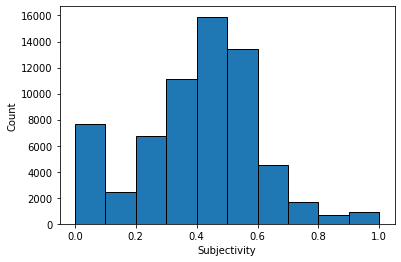

In [ ]:
hist, edges = np.histogram(df.subjectivity, bins=10)
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Subjectivity")
plt.ylabel("Count")

plt.show()

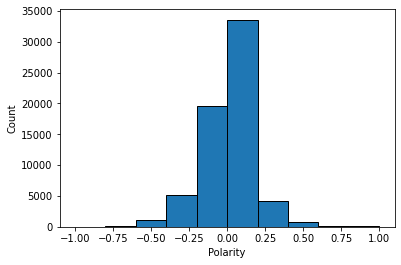

In [ ]:
hist, edges = np.histogram(df.polarity, bins=10)
plt.bar(edges[:-1], hist, align="edge", ec="k", width=np.diff(edges))
plt.xlabel("Polarity")
plt.ylabel("Count")

plt.show()

In [ ]:
pip install text2emotion

     |████████████████████████████████| 57 kB 4.0 MB/s 
     |████████████████████████████████| 170 kB 16.7 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=9c0694756adf89474b5a9938fc846cc6296a7e88fe5e9b8dd3e18f3601d8b264
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [ ]:
import text2emotion as te

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
dc = te.get_emotion(df.consumer_complaint_narrative[553090])
dc

{'Angry': 0.04, 'Fear': 0.52, 'Happy': 0.07, 'Sad': 0.26, 'Surprise': 0.11}

In [ ]:
pd.DataFrame(dc, index=[0])

,Happy,Angry,Surprise,Sad,Fear
0,0.0,0.25,0.25,0.0,0.5


In [ ]:
emo = lambda x: te.get_emotion(x)

In [ ]:
dfsample = df.sample(5)

In [ ]:
dfsample['emo'] = dfsample['complaint_cleaned'].apply(emo)

In [ ]:
dfsample = pd.concat([dfsample, dfsample["emo"].apply(pd.Series)], axis=1)

In [ ]:
dfsample.head()

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,label,complaint_cleaned,char_count,word_count,clean_split,emo,Happy,Angry,Surprise,Sad,Fear
40732,12/01/2015,6,i have authorized electronicpaperless delivery...,Capital One,NY,104XX,Web,12/04/2015,Closed with explanation,Yes,Yes,Bank account or service,authorize electronicpaperless delivery monthly...,1120,146,"['authorize', 'electronicpaperless', 'delivery...","{'Happy': 0.14, 'Angry': 0.0, 'Surprise': 0.08...",0.14,0.0,0.08,0.10,0.68
40149,10/21/2015,2,i am disputing conflicting payoff amounts a we...,"PennyMac Loan Services, LLC",IA,522XX,Web,10/21/2015,Closed with explanation,Yes,No,Mortgage,dispute conflict payoff amount week apart mort...,59,8,"['dispute', 'conflict', 'payoff', 'amount', 'w...","{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, ...",0.00,0.0,0.00,0.33,0.67
13989,06/09/2015,1,i recently checked my student account from the...,Immediate Credit Recovery,NY,113XX,Web,06/09/2015,Closed with explanation,Yes,No,Debt collection,recently check student account college socalle...,251,33,"['recently', 'check', 'student', 'account', 'c...","{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.17,...",0.00,0.0,0.17,0.00,0.83
22425,08/21/2015,6,i wired my aunt 100000 the wire was sent from ...,JPMorgan Chase & Co.,VA,235XX,Web,08/21/2015,Closed with explanation,Yes,Yes,Bank account or service,wire aunt wire send account checking account j...,240,38,"['wire', 'aunt', 'wire', 'send', 'account', 'c...","{'Happy': 0.06, 'Angry': 0.0, 'Surprise': 0.19...",0.06,0.0,0.19,0.25,0.50
4558,04/02/2015,3,i disputed my equifax report in with supportin...,Equifax,VA,220XX,Web,04/02/2015,Closed with explanation,Yes,Yes,Credit reporting,dispute equifax report support documentation s...,187,22,"['dispute', 'equifax', 'report', 'support', 'd...","{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, ...",0.00,0.0,0.00,0.00,1.00


# Text Summarization

In [ ]:
#Original Dataset before cleaning used for text summarization
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/consumer_complaints.csv')
df = df.dropna(subset=['consumer_complaint_narrative', 'product'])
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
190126,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,NaN,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
190135,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,Due to inconsistencies in the amount owed that...,NaN,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524
190207,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I have an open and current mortgage with Chase...,NaN,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137


In [ ]:
pip install sumy

     |████████████████████████████████| 87 kB 5.0 MB/s 
     |████████████████████████████████| 10.1 MB 17.3 MB/s 
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21711 sha256=ee634e3fa64b560c12887bbdb1453592e9741bdb9b8c19d079890c80cdc2af9f
  Stored in directory: /root/.cache/pip/wheels/d4/bf/51/81d27ad638e1a6dca4f362ecc33d1e2c764b8ea7ec751b8fc1
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=61f0c2123ab33e90ce588a930837a3ba942401a427ead38fc3fb98c9d464fb29
  Stored in directory: /root/.cache/pip/wheels/57/e8/3f/120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built breadability pycountry


In [ ]:
#Plain text parsers since we are parsing through text
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words


In [ ]:
df.consumer_complaint_narrative[553090]

'I recently became aware that Amerisave Mortgage Corporation participated in some illegal practices that harm customers. I did not know at the time ( until recently ) that I had any legal recourse for an issue I had, and I would like to seek restitution at this time. I applied for a 30 year fixed rate mortgage loan with Amerisave on XXXX/XXXX/06 ( loan application # XXXX ). As part of the process I paid for an appraisal. I also paid for " discount points \'\' to lower the interest rate on the mortgage. These payments were made through my credit card on XXXX/XXXX/06, and I have those records. Shortly after I cancelled the loan, as the terms had not been satisfactory. It was my understanding that the {$390.00} appraisal fee was non-refundable, but the {$3000.00} that was paid in discount points should have been reimbursed. I inquired many times to Amerisave to get this {$3000.00} reimbursement and they said they could not refund the money. Not only was this bad customer service, but caus

In [ ]:
txt = df.consumer_complaint_narrative[553090]
txt

'I recently became aware that Amerisave Mortgage Corporation participated in some illegal practices that harm customers. I did not know at the time ( until recently ) that I had any legal recourse for an issue I had, and I would like to seek restitution at this time. I applied for a 30 year fixed rate mortgage loan with Amerisave on XXXX/XXXX/06 ( loan application # XXXX ). As part of the process I paid for an appraisal. I also paid for " discount points \'\' to lower the interest rate on the mortgage. These payments were made through my credit card on XXXX/XXXX/06, and I have those records. Shortly after I cancelled the loan, as the terms had not been satisfactory. It was my understanding that the {$390.00} appraisal fee was non-refundable, but the {$3000.00} that was paid in discount points should have been reimbursed. I inquired many times to Amerisave to get this {$3000.00} reimbursement and they said they could not refund the money. Not only was this bad customer service, but caus

In [ ]:
parser = PlaintextParser.from_string(txt, Tokenizer("english"))

In [ ]:
stemmer = Stemmer("english")
summarizer = LsaSummarizer(stemmer)
summarizer.stop_words = get_stop_words("english")

for sentence in summarizer(parser.document, 2):
  print(sentence)

I recently became aware that Amerisave Mortgage Corporation participated in some illegal practices that harm customers.
It was my understanding that the {$390.00} appraisal fee was non-refundable, but the {$3000.00} that was paid in discount points should have been reimbursed.


In [ ]:
from sumy.summarizers.text_rank import TextRankSummarizer
summarizer_3 = TextRankSummarizer()
summary_3 =summarizer_3(parser.document,2)
for sentence in summary_3:
 print(sentence)

I did not know at the time ( until recently ) that I had any legal recourse for an issue I had, and I would like to seek restitution at this time.
I did not know at the time that I had any rights to get this money back, and was told to the contrary.


In [ ]:
from sumy.summarizers.luhn import LuhnSummarizer
summarizer_1 = LuhnSummarizer()
summary_1 =summarizer_1(parser.document,2)
for sentence in summary_1:
  print(sentence)

I did not know at the time ( until recently ) that I had any legal recourse for an issue I had, and I would like to seek restitution at this time.
I did not know at the time that I had any rights to get this money back, and was told to the contrary.


In [ ]:
from sumy.summarizers.lex_rank import LexRankSummarizer 
summarizer = LexRankSummarizer()

summary = summarizer(parser.document, 2) 
for sentence in summary:
 print(sentence)

It was my understanding that the {$390.00} appraisal fee was non-refundable, but the {$3000.00} that was paid in discount points should have been reimbursed.
I did not know at the time that I had any rights to get this money back, and was told to the contrary.


# Machine Learning Modelling

In [ ]:
#Cleaned Data
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_clean_03_LDA.csv')
df.head()

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,label,complaint_cleaned,char_count,word_count,clean_split
0,03/19/2015,1,has claimed i owe them 2700 for years despite ...,"Diversified Consultants, Inc.",NY,121XX,Web,03/19/2015,Closed with explanation,Yes,No,Debt collection,claim owe year despite proof payment send canc...,142,22,"['claim', 'owe', 'year', 'despite', 'proof', '..."
1,03/19/2015,5,due to inconsistencies in the amount owed that...,M&T Bank Corporation,VA,221XX,Web,03/19/2015,Closed with explanation,Yes,No,Loans,inconsistency owe tell m t bank report credit ...,673,101,"['inconsistency', 'owe', 'tell', 'bank', 'repo..."
2,03/19/2015,2,in my wages that i earned at my job decreased ...,Wells Fargo & Company,CA,946XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,wage earn job decrease half know trouble home ...,1623,239,"['wage', 'earn', 'job', 'decrease', 'half', 'k..."
3,03/19/2015,2,i have an open and current mortgage with chase...,JPMorgan Chase & Co.,CA,900XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,open current mortgage chase bank chase report ...,241,34,"['open', 'current', 'mortgage', 'chase', 'bank..."
4,03/19/2015,2,was submitted at the time i submitted this com...,Rushmore Loan Management Services LLC,CA,956XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,submit time submit complaint deal rushmore mor...,745,98,"['submit', 'time', 'submit', 'complaint', 'dea..."


In [ ]:
dfcomplains = df[["product","complaint_cleaned"]]

In [ ]:
dfcomplains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64989 entries, 0 to 64988
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product            64989 non-null  int64 
 1   complaint_cleaned  64989 non-null  object
dtypes: int64(1), object(1)
memory usage: 1015.6+ KB


In [ ]:
y = df['product']
X = df['complaint_cleaned']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size = 0.2,
    random_state = 42
)

In [ ]:
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

#count_vect.fit(df['complaint_cleaned'].astype(str))
count_vect.fit(X_train)

X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

In [ ]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)

#tfidf_vect.fit(df['complaint_cleaned'])
tfidf_vect.fit(X_train)

X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

CPU times: user 5.15 s, sys: 33.3 ms, total: 5.18 s
Wall time: 5.16 s


In [ ]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)

#tfidf_vect_ngram.fit(df['complaint_cleaned'])
tfidf_vect_ngram.fit(X_train)

X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

CPU times: user 29.9 s, sys: 822 ms, total: 30.8 s
Wall time: 30.6 s


In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit train data
    classifier.fit(feature_vector_train, label)

    # predict on test
    predictions = classifier.predict(feature_vector_valid)

    return accuracy_score(y_test, predictions)

In [ ]:
def cls_report(classifier, feature_vector_train, label, feature_vector_valid):
   
    classifier.fit(feature_vector_train, label)    
    predictions = classifier.predict(feature_vector_valid)

    precision, recall, fscore, support = precision_recall_fscore_support(y_test, predictions.round())
    print(classification_report(y_test, predictions.round()))

In [ ]:
resultsDF = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors'
                                  ])

In [ ]:
# Naive Bayes on Count Vectors
accuracy1 = train_model(MultinomialNB(), X_train_count, y_train, X_test_count)
accuracy1

0.8395907062625019

In [ ]:
accuracy2 = train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf)
accuracy2

0.8305893214340668

In [ ]:
accuracy3 = train_model(MultinomialNB(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
accuracy3

0.7945068472072626

In [ ]:
cls_report(MultinomialNB(), X_train_count, y_train, X_test_count)

              precision    recall  f1-score   support

           1       0.84      0.83      0.84      3532
           2       0.93      0.94      0.93      2949
           3       0.79      0.84      0.81      2517
           4       0.77      0.80      0.79      1536
           5       0.80      0.71      0.75      1293
           6       0.85      0.81      0.83      1171

    accuracy                           0.84     12998
   macro avg       0.83      0.82      0.83     12998
weighted avg       0.84      0.84      0.84     12998



In [ ]:
resultsDF.loc['Naïve Bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3
    }

In [ ]:
resultsDF

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors
Naïve Bayes,0.839591,0.830589,0.794507


In [ ]:
# Support Vector Machine 
accuracy1 = train_model(LinearSVC(), X_train_count, y_train, X_test_count)
accuracy1

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8265117710416987

In [ ]:
accuracy2 = train_model(LinearSVC(), X_train_tfidf, y_train, X_test_tfidf)
accuracy2

0.8552084936144022

In [ ]:
accuracy3 = train_model(LinearSVC(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
accuracy3

0.8005077704262195

In [ ]:
resultsDF.loc['SVM'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3
    }

In [ ]:
resultsDF

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors
Naïve Bayes,0.839591,0.830589,0.794507
SVM,0.826512,0.855208,0.800508


In [ ]:
# clf = svm.SVC(kernel='linear', C=1, random_state=42)
# scores = cross_val_score(clf, X, y, cv=5)
# scores


In [ ]:
cls_report(LinearSVC(), X_train_count, y_train, X_test_count)

              precision    recall  f1-score   support

           1       0.81      0.85      0.83      3532
           2       0.92      0.91      0.91      2949
           3       0.84      0.85      0.85      2517
           4       0.76      0.77      0.77      1536
           5       0.75      0.68      0.71      1293
           6       0.78      0.74      0.76      1171

    accuracy                           0.83     12998
   macro avg       0.81      0.80      0.80     12998
weighted avg       0.83      0.83      0.83     12998



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Random Forest
accuracy1 = train_model(RandomForestClassifier(n_estimators = 100), X_train_count, y_train, X_test_count)
accuracy1

0.8307431912601939

In [ ]:
accuracy2 = train_model(RandomForestClassifier(n_estimators = 100), X_train_tfidf, y_train, X_test_tfidf)
accuracy2

0.8495153100476996

In [ ]:
accuracy3 = train_model(RandomForestClassifier(n_estimators = 100), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
accuracy3

0.7746576396368672

In [ ]:
resultsDF.loc['Random Forest'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3
    }

In [ ]:
resultsDF

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors
Naïve Bayes,0.839591,0.830589,0.794507
SVM,0.826512,0.855208,0.800508
Random Forest,0.830743,0.849515,0.774658


In [ ]:
cls_report(RandomForestClassifier(n_estimators = 100), X_train_count, y_train, X_test_count)

              precision    recall  f1-score   support

           1       0.78      0.91      0.84      3532
           2       0.85      0.95      0.90      2949
           3       0.82      0.86      0.84      2517
           4       0.83      0.72      0.77      1536
           5       0.88      0.47      0.62      1293
           6       0.91      0.73      0.81      1171

    accuracy                           0.83     12998
   macro avg       0.85      0.77      0.80     12998
weighted avg       0.83      0.83      0.82     12998



In [ ]:
# Gradient Boosting
accuracy1 = train_model(GradientBoostingClassifier(), X_train_count, y_train, X_test_count)
accuracy1

0.8314356054777658

In [ ]:
accuracy2 = train_model(GradientBoostingClassifier(), X_train_tfidf, y_train, X_test_tfidf)
accuracy2

0.8354362209570703

In [ ]:
accuracy3 = train_model(GradientBoostingClassifier(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
accuracy3

0.7157254962301892

In [ ]:
resultsDF.loc['GradientBoosting'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3
    }

In [ ]:
resultsDF

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors
Naïve Bayes,0.839591,0.830589,0.794507
SVM,0.826512,0.855208,0.800508
Random Forest,0.830743,0.849515,0.774658
GradientBoosting,0.831436,0.835436,0.715725


In [ ]:
cls_report(GradientBoostingClassifier(), X_train_count, y_train, X_test_count)

In [ ]:
# XGB 
accuracy1 = train_model(xgb.XGBClassifier(learning_rate = 0.3, max_depth = 6), X_train_count, y_train, X_test_count)
accuracy1

0.860517002615787

In [ ]:
accuracy2 = train_model(xgb.XGBClassifier(learning_rate = 0.3, max_depth = 6), X_train_tfidf, y_train, X_test_tfidf)
accuracy2

0.8617479612248038

In [ ]:
accuracy3 = train_model(xgb.XGBClassifier(learning_rate = 0.3, max_depth = 6), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
accuracy3

0.775888598245884

In [ ]:
resultsDF.loc['XGBoost'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3
    }

In [ ]:
resultsDF

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors
Naïve Bayes,0.839591,0.830589,0.794507
SVM,0.826512,0.855208,0.800508
Random Forest,0.830743,0.849515,0.774658
GradientBoosting,0.831436,0.835436,0.715725
XGBoost,0.860517,0.861748,0.775889


In [ ]:
cls_report(xgb.XGBClassifier(learning_rate = 0.3, max_depth = 6), X_train_count, y_train, X_test_count)

              precision    recall  f1-score   support

           1       0.83      0.88      0.86      3532
           2       0.93      0.94      0.94      2949
           3       0.85      0.85      0.85      2517
           4       0.82      0.82      0.82      1536
           5       0.81      0.73      0.77      1293
           6       0.89      0.80      0.84      1171

    accuracy                           0.86     12998
   macro avg       0.86      0.84      0.85     12998
weighted avg       0.86      0.86      0.86     12998



# Deep Learning Modelling

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_clean_03_LDA.csv')
df.head()

,date_received,product,complaint,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,label,complaint_cleaned,char_count,word_count,clean_split
0,03/19/2015,1,has claimed i owe them 2700 for years despite ...,"Diversified Consultants, Inc.",NY,121XX,Web,03/19/2015,Closed with explanation,Yes,No,Debt collection,claim owe year despite proof payment send canc...,142,22,"['claim', 'owe', 'year', 'despite', 'proof', '..."
1,03/19/2015,5,due to inconsistencies in the amount owed that...,M&T Bank Corporation,VA,221XX,Web,03/19/2015,Closed with explanation,Yes,No,Loans,inconsistency owe tell m t bank report credit ...,673,101,"['inconsistency', 'owe', 'tell', 'bank', 'repo..."
2,03/19/2015,2,in my wages that i earned at my job decreased ...,Wells Fargo & Company,CA,946XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,wage earn job decrease half know trouble home ...,1623,239,"['wage', 'earn', 'job', 'decrease', 'half', 'k..."
3,03/19/2015,2,i have an open and current mortgage with chase...,JPMorgan Chase & Co.,CA,900XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,open current mortgage chase bank chase report ...,241,34,"['open', 'current', 'mortgage', 'chase', 'bank..."
4,03/19/2015,2,was submitted at the time i submitted this com...,Rushmore Loan Management Services LLC,CA,956XX,Web,03/19/2015,Closed with explanation,Yes,Yes,Mortgage,submit time submit complaint deal rushmore mor...,745,98,"['submit', 'time', 'submit', 'complaint', 'dea..."


In [ ]:
dfcomplains = df[["product","complaint_cleaned"]]

In [ ]:
y = df['product']
X = df['complaint_cleaned']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from keras.models import Model
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn import preprocessing

In [ ]:
total_complaints = np.append(X_train.values,X_test.values)

In [ ]:
MAX_SEQUENCE_LENGTH = max([len(c.split()) for c in total_complaints])

In [ ]:
MAX_SEQUENCE_LENGTH

357

In [ ]:
max_length = 357

In [ ]:
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(X_train.values) #total_complaints
train_sequences = tokenizer.texts_to_sequences(X_train.values)
test_sequences = tokenizer.texts_to_sequences(X_test.values)

In [ ]:
word_index = tokenizer.word_index# dictionary containing words and their index
print('Found %s unique tokens.' % len(word_index))

Found 48336 unique tokens.


In [ ]:
len(train_sequences), len(test_sequences)

(51991, 12998)

In [ ]:
train_data = pad_sequences(train_sequences, maxlen=max_length,padding='post')
test_data = pad_sequences(test_sequences, maxlen=max_length,padding='post')

In [ ]:
print(train_data.shape)
print(test_data.shape)

(51991, 357)
(12998, 357)


In [ ]:
enc = preprocessing.LabelEncoder()
train_labels = enc.fit_transform(y_train)
test_labels = enc.fit_transform(y_test)

In [ ]:
print(enc.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

[1 2 3 4 5 6]
(array([0, 1, 2, 3, 4, 5]), array([14006, 11919,  9996,  6323,  5219,  4528]))
(array([0, 1, 2, 3, 4, 5]), array([3502, 2980, 2499, 1581, 1304, 1132]))


In [ ]:
labels_train = to_categorical(np.asarray(train_labels))
labels_test = to_categorical(np.asarray(test_labels))
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', labels_train.shape)
print('Shape of label tensor:', labels_test.shape)

Shape of data tensor: (51991, 357)
Shape of label tensor: (51991, 6)
Shape of label tensor: (12998, 6)


In [ ]:
max_vocab_length = 100000

**RNN - LSTM**

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_1"))
model.add(Bidirectional(LSTM(100, dropout = 0.2)))
model.add(Dense(6,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
train_data.shape, labels_train.shape, test_data.shape, labels_test.shape

((51991, 357), (51991, 6), (12998, 357), (12998, 6))

In [ ]:
history = model.fit(train_data, labels_train,
 batch_size=64,
 epochs=6,
 validation_data=(test_data, labels_test))

Epoch 1/6
813/813 [==============================] - 39s 43ms/step - loss: 0.6369 - acc: 0.7905 - val_loss: 0.4578 - val_acc: 0.8544
Epoch 2/6
813/813 [==============================] - 35s 43ms/step - loss: 0.4210 - acc: 0.8665 - val_loss: 0.4347 - val_acc: 0.8594
Epoch 3/6
813/813 [==============================] - 35s 43ms/step - loss: 0.3785 - acc: 0.8792 - val_loss: 0.4158 - val_acc: 0.8634
Epoch 4/6
813/813 [==============================] - 35s 43ms/step - loss: 0.3525 - acc: 0.8875 - val_loss: 0.4057 - val_acc: 0.8713
Epoch 5/6
813/813 [==============================] - 36s 44ms/step - loss: 0.3306 - acc: 0.8933 - val_loss: 0.4039 - val_acc: 0.8678
Epoch 6/6
813/813 [==============================] - 36s 44ms/step - loss: 0.3139 - acc: 0.8995 - val_loss: 0.4077 - val_acc: 0.8677


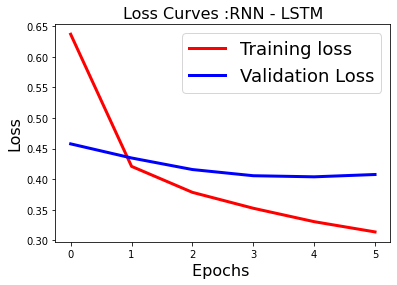

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN - LSTM',fontsize=16)
plt.show()

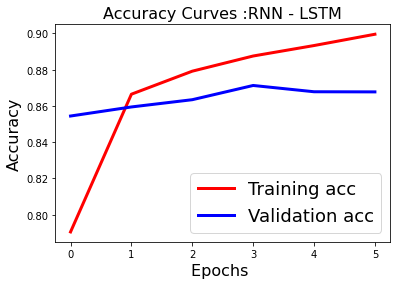

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training acc', 'Validation acc'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves :RNN - LSTM',fontsize=16)
plt.show()

In [ ]:
predicted=model.predict(test_data)
predicted

array([[9.9592185e-01, 1.4082450e-04, 2.2815407e-04, 2.1259037e-03,
        1.4245440e-03, 1.5871601e-04],
       [7.5869650e-01, 4.2537659e-02, 1.0076096e-02, 1.1456711e-01,
        1.9632146e-02, 5.4490462e-02],
       [2.8432687e-03, 9.8195964e-01, 9.7864913e-03, 4.0010412e-04,
        8.1123196e-04, 4.1993042e-03],
       ...,
       [5.7520688e-02, 4.3603666e-03, 9.3206578e-01, 3.5370747e-03,
        1.3510595e-03, 1.1650961e-03],
       [8.4971446e-01, 8.8430959e-04, 1.6781393e-03, 1.0060729e-02,
        1.3689034e-01, 7.7208172e-04],
       [1.8841275e-03, 8.7543635e-04, 1.1112154e-03, 3.3360463e-02,
        3.5214571e-03, 9.5924729e-01]], dtype=float32)

In [ ]:
#model evaluation
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted.round())
print('precision: \n{}'.format(precision))
print('recall: \n{}'.format(recall))
print('fscore: \n{}'.format(fscore))
print('support: \n{}'.format(support))
print("############################")

precision: 
[0.85952516 0.94811321 0.8893066  0.80072246 0.87295826 0.93650794]
recall: 
[0.86836094 0.9442953  0.85194078 0.84123972 0.73773006 0.72968198]
fscore: 
[0.86392045 0.9462004  0.87022277 0.82048118 0.7996675  0.82025819]
support: 
[3502 2980 2499 1581 1304 1132]
############################


In [ ]:
df['product'].unique()

array([1, 5, 2, 4, 3, 6])

In [ ]:
print(classification_report(labels_test, predicted.round()))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3502
           1       0.95      0.94      0.95      2980
           2       0.89      0.85      0.87      2499
           3       0.80      0.84      0.82      1581
           4       0.87      0.74      0.80      1304
           5       0.94      0.73      0.82      1132

   micro avg       0.88      0.85      0.87     12998
   macro avg       0.88      0.83      0.85     12998
weighted avg       0.89      0.85      0.87     12998
 samples avg       0.85      0.85      0.85     12998



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy_score(labels_test, predicted.round())

0.8541314048315125

**CNN**

In [ ]:
#vocab_size = len(tokenizer.word_index)+1
#EMBEDDING_DIM = 300
#max_length = 357

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3"))
model.add(Dropout(0.3))
model.add(Conv1D(64, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(loss='categorical_crossentropy',
 optimizer="rmsprop",
 metrics=['acc'])

In [ ]:
train_data.shape, labels_train.shape, test_data.shape, labels_test.shape

((51991, 357), (51991, 6), (12998, 357), (12998, 6))

In [ ]:
history = model.fit(train_data, labels_train,
 batch_size=64,
 epochs=6,
 validation_data=(test_data, labels_test))

Epoch 1/6
813/813 [==============================] - 9s 8ms/step - loss: 0.8100 - acc: 0.7212 - val_loss: 0.5055 - val_acc: 0.8482
Epoch 2/6
813/813 [==============================] - 7s 8ms/step - loss: 0.4957 - acc: 0.8432 - val_loss: 0.4817 - val_acc: 0.8550
Epoch 3/6
813/813 [==============================] - 7s 8ms/step - loss: 0.4451 - acc: 0.8612 - val_loss: 0.4705 - val_acc: 0.8574
Epoch 4/6
813/813 [==============================] - 7s 8ms/step - loss: 0.4147 - acc: 0.8713 - val_loss: 0.4475 - val_acc: 0.8643
Epoch 5/6
813/813 [==============================] - 7s 8ms/step - loss: 0.3918 - acc: 0.8773 - val_loss: 0.4820 - val_acc: 0.8633
Epoch 6/6
813/813 [==============================] - 7s 8ms/step - loss: 0.3743 - acc: 0.8828 - val_loss: 0.4556 - val_acc: 0.8620


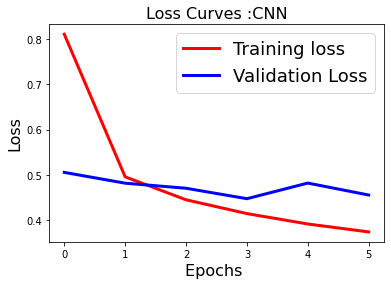

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show()

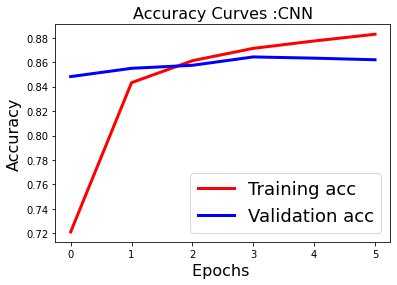

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training acc', 'Validation acc'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves :CNN',fontsize=16)
plt.show()

In [ ]:
predicted=model.predict(test_data)
predicted

array([[9.7512555e-01, 5.5827495e-05, 6.3257228e-04, 1.1376488e-03,
        2.2997428e-02, 5.1082370e-05],
       [4.2376497e-01, 3.4655795e-02, 6.0290378e-03, 3.5242966e-01,
        1.6240759e-02, 1.6687980e-01],
       [8.0370010e-05, 9.9991965e-01, 1.6424978e-10, 3.3736124e-15,
        1.9071680e-09, 1.5256314e-16],
       ...,
       [4.9543232e-02, 1.1013716e-03, 9.3508130e-01, 6.6338880e-03,
        5.9255054e-03, 1.7146745e-03],
       [9.5019186e-01, 1.4379219e-04, 1.5731617e-04, 1.2530271e-03,
        4.8099034e-02, 1.5504954e-04],
       [2.8960477e-03, 1.3551676e-03, 6.6238357e-04, 3.2478251e-02,
        5.5924442e-04, 9.6204895e-01]], dtype=float32)

In [ ]:
#model evaluation
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(labels_test, predicted.round())
print('precision: \n{}'.format(precision))
print('recall: \n{}'.format(recall))
print('fscore: \n{}'.format(fscore))
print('support: \n{}'.format(support))
print("############################")

precision: 
[0.88076214 0.94496331 0.81140988 0.85282258 0.84196664 0.89624506]
recall: 
[0.81838949 0.95067114 0.89355742 0.80265655 0.73542945 0.80123675]
fscore: 
[0.84843102 0.94780863 0.85050467 0.82697947 0.78510029 0.84608209]
support: 
[3502 2980 2499 1581 1304 1132]
############################


In [ ]:
print(classification_report(labels_test, predicted.round()))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3502
           1       0.94      0.95      0.95      2980
           2       0.81      0.89      0.85      2499
           3       0.85      0.80      0.83      1581
           4       0.84      0.74      0.79      1304
           5       0.90      0.80      0.85      1132

   micro avg       0.88      0.85      0.86     12998
   macro avg       0.87      0.83      0.85     12998
weighted avg       0.88      0.85      0.86     12998
 samples avg       0.85      0.85      0.85     12998



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy_score(labels_test, predicted.round())

0.8514386828742884

In [ ]:
0.8541, 0.8514

(0.8541, 0.8514)

# Extra Modelling on Company Response

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64989 entries, 0 to 64988
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 64989 non-null  object
 1   product                       64989 non-null  int64 
 2   complaint                     64989 non-null  object
 3   company                       64989 non-null  object
 4   state                         64989 non-null  object
 5   zipcode                       64989 non-null  object
 6   submitted_via                 64989 non-null  object
 7   date_sent_to_company          64989 non-null  object
 8   company_response_to_consumer  64989 non-null  object
 9   timely_response               64989 non-null  object
 10  consumer_disputed             64989 non-null  object
 11  label                         64989 non-null  object
 12  complaint_cleaned             64989 non-null  object
 13  char_count      

In [ ]:
dfres =  df.company_response_to_consumer.value_counts().to_frame()
dfres

,company_response_to_consumer
Closed with explanation,49886
Closed with non-monetary relief,8338
Closed with monetary relief,4488
Closed,1754
Untimely response,523


Text(0.5, 1.0, 'Company Responses')

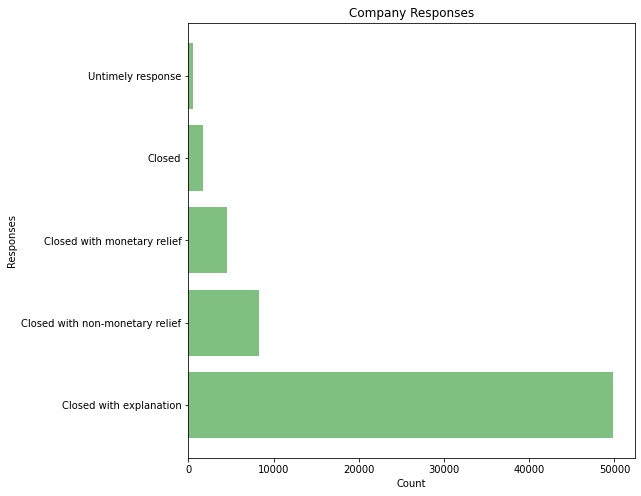

In [ ]:
plt.figure(figsize=(8,8))
plt.barh(dfres.index, dfres.company_response_to_consumer, color='green', alpha=0.5)
plt.xlabel('Count')
plt.ylabel('Responses')
plt.title('Company Responses')

In [ ]:
dfresp = df[["product","complaint_cleaned","company_response_to_consumer"]]
dfresp.head()

,product,complaint_cleaned,company_response_to_consumer
0,1,claim owe year despite proof payment send canc...,Closed with explanation
1,5,inconsistency owe tell m t bank report credit ...,Closed with explanation
2,2,wage earn job decrease half know trouble home ...,Closed with explanation
3,2,open current mortgage chase bank chase report ...,Closed with explanation
4,2,submit time submit complaint deal rushmore mor...,Closed with explanation


In [ ]:
len = 4488

In [ ]:
dfresp['response'] = dfresp['company_response_to_consumer']

In [ ]:
dfresp.head()

,product,complaint_cleaned,company_response_to_consumer,response
0,1,claim owe year despite proof payment send canc...,Closed with explanation,Closed with explanation
1,5,inconsistency owe tell m t bank report credit ...,Closed with explanation,Closed with explanation
2,2,wage earn job decrease half know trouble home ...,Closed with explanation,Closed with explanation
3,2,open current mortgage chase bank chase report ...,Closed with explanation,Closed with explanation
4,2,submit time submit complaint deal rushmore mor...,Closed with explanation,Closed with explanation


In [ ]:
dfresp['response'] = dfresp['response'].astype('category')
dfresp['response_cat'] = dfresp['response'].cat.codes
dfresp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,product,complaint_cleaned,company_response_to_consumer,response,response_cat
0,1,claim owe year despite proof payment send canc...,Closed with explanation,Closed with explanation,1
1,5,inconsistency owe tell m t bank report credit ...,Closed with explanation,Closed with explanation,1
2,2,wage earn job decrease half know trouble home ...,Closed with explanation,Closed with explanation,1
3,2,open current mortgage chase bank chase report ...,Closed with explanation,Closed with explanation,1
4,2,submit time submit complaint deal rushmore mor...,Closed with explanation,Closed with explanation,1
...,...,...,...,...,...
64984,3,report incorrectly payment time vehicle turn t...,Closed with explanation,Closed with explanation,1
64985,3,reflect incorrect payment status time,Closed with explanation,Closed with explanation,1
64986,5,pay month direct debit withdrawal checking acc...,Closed with explanation,Closed with explanation,1
64987,2,recently aware amerisave mortgage corporation ...,Closed with explanation,Closed with explanation,1


In [ ]:
del dfresp['company_response_to_consumer']

In [ ]:
dfresp.head()

,product,complaint_cleaned,response,response_cat
0,1,claim owe year despite proof payment send canc...,Closed with explanation,1
1,5,inconsistency owe tell m t bank report credit ...,Closed with explanation,1
2,2,wage earn job decrease half know trouble home ...,Closed with explanation,1
3,2,open current mortgage chase bank chase report ...,Closed with explanation,1
4,2,submit time submit complaint deal rushmore mor...,Closed with explanation,1


In [ ]:
dfresp.response_cat.value_counts()

1    49886
3     8338
2     4488
0     1754
4      523
Name: response_cat, dtype: int64

In [ ]:
filter = [2,0,4]

df2 = dfresp[dfresp['response_cat'].isin(filter)]

In [ ]:
df1 = dfresp[dfresp['response_cat'] == 1]
df3 = dfresp[dfresp['response_cat'] == 3]

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6765 entries, 8 to 64977
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   product            6765 non-null   int64   
 1   complaint_cleaned  6765 non-null   object  
 2   response           6765 non-null   category
 3   response_cat       6765 non-null   int8    
dtypes: category(1), int64(1), int8(1), object(1)
memory usage: 172.0+ KB


In [ ]:
usize = 4488

In [ ]:
df1_under = df1.sample(usize)
df3_under = df3.sample(usize)


In [ ]:
dfresp_under = pd.concat([
                df1_under.reset_index(drop = True), df2.reset_index(drop = True), df3_under.reset_index(drop = True)
                ],
                axis = 0)



dfresp_under.head()

,product,complaint_cleaned,response,response_cat
0,6,fund take acct suppose account see check withd...,Closed with explanation,1
1,4,past discover credit card year effort remedy s...,Closed with explanation,1
2,5,start negotiation time begin garnish paycheck ...,Closed with explanation,1
3,2,move contract house plan put obtain loan infor...,Closed with explanation,1
4,6,issue dollar worth deposit transaction couple ...,Closed with explanation,1


In [ ]:
dfresp_under.response.value_counts()

Closed with non-monetary relief    4488
Closed with monetary relief        4488
Closed with explanation            4488
Closed                             1754
Untimely response                   523
Name: response, dtype: int64

In [ ]:
dfresp_under.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15741 entries, 0 to 4487
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   product            15741 non-null  int64   
 1   complaint_cleaned  15741 non-null  object  
 2   response           15741 non-null  category
 3   response_cat       15741 non-null  int8    
dtypes: category(1), int64(1), int8(1), object(1)
memory usage: 399.9+ KB


In [ ]:
y = dfresp_under['response_cat']
X = dfresp_under['complaint_cleaned']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size = 0.2,
    random_state = 42
)

In [ ]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(dfresp_under['complaint_cleaned'])
#tfidf_vect.fit(X_train)

X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)
CPU times: user 1.42 s, sys: 17.8 ms, total: 1.44 s
Wall time: 1.44 s


In [ ]:
## helper function

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    return accuracy_score(y_test, predictions)

In [ ]:
## helper function 2

def cls_report(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    precision, recall, fscore, support = score(y_test, predictions.round())
    print(classification_report(y_test, predictions.round()))

    #return accuracy_score(y_test, predictions)

In [ ]:
%%time
# Naive Bayes on Count Vectors
accuracy1 = train_model(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf)
print('NB, Count Vectors Accuracy   : %.4f\n' % accuracy1)

NB, Count Vectors Accuracy   : 0.5595

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 14.5 ms


In [ ]:
cls_report(MultinomialNB(), X_train_tfidf, y_train, X_test_tfidf)

              precision    recall  f1-score   support

           0       0.82      0.09      0.17       350
           1       0.46      0.42      0.44       903
           2       0.68      0.83      0.74       930
           3       0.51      0.68      0.58       855
           4       0.00      0.00      0.00       111

    accuracy                           0.56      3149
   macro avg       0.49      0.40      0.39      3149
weighted avg       0.56      0.56      0.52      3149



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(12592, 5000)

In [ ]:
accuracy2 = train_model(xgb.XGBClassifier(learning_rate = 0.3, max_depth = 6), X_train_tfidf, y_train, X_test_tfidf)
print('Count Vectors    : %.4f\n' % accuracy2)

Count Vectors    : 0.5697



In [ ]:
cls_report(xgb.XGBClassifier(learning_rate = 0.3, max_depth = 6), X_train_tfidf, y_train, X_test_tfidf)

              precision    recall  f1-score   support

           0       0.56      0.24      0.34       350
           1       0.45      0.50      0.47       903
           2       0.71      0.80      0.75       930
           3       0.55      0.59      0.57       855
           4       0.29      0.06      0.10       111

    accuracy                           0.57      3149
   macro avg       0.51      0.44      0.45      3149
weighted avg       0.56      0.57      0.55      3149

